## <center>Exercise - DCGANs</center>

**IMPORTANT: Run this code in Google-Colab**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

from tensorflow.keras.datasets import fashion_mnist as fm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Conv2DTranspose, Reshape, LeakyReLU, Dropout, BatchNormalization

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

#### Data

In [2]:
(X_train, y_train), (X_test, y_test) = fm.load_data()

4431872/4422102 [==============================] - 0s 0us/step


#### Data visualization

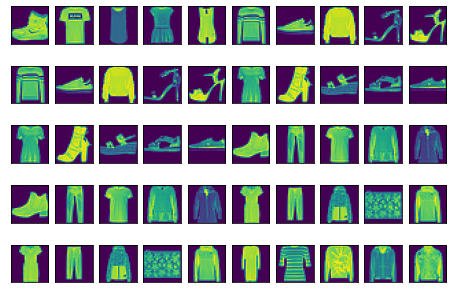

<Figure size 360x720 with 0 Axes>

In [3]:
fig, ax = plt.subplots(5, 10)
plt.figure(figsize=(5, 10))
fig.tight_layout(pad=-1)

for i in range(5):
    for j in range(10):
        ax[i,j].imshow(X_train[5*i+j])
        ax[i, j].xaxis.set_visible(False)
        ax[i, j].yaxis.set_visible(False)


#### Reshape and rescale

In [4]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train.reshape(-1, 28*28))
X_test = scaler.transform(X_test.reshape(-1,28*28))

X_train = X_train.reshape(-1, 28,28,1)
X_test = X_test.reshape(-1,28,28,1)

### Building the model

#### Generator

In [5]:
codings_size = 100

def gen():
    
  generator = Sequential()
  generator.add(Dense(7 * 7 * 256, input_shape=[codings_size,]))
  generator.add(Reshape([7, 7, 256]))
  generator.add(BatchNormalization())

  generator.add(Conv2DTranspose(128, kernel_size=2, strides=1, padding="same",
                                  activation=LeakyReLU(0.4)))
  # Since we use this model to generate images from one-dimensional input, using Transposed Convolution layers is the best 
  # option. Transposed Convolution layers work just the opposite of the Convolution layer. They increase the definition of 
  # image data.

  generator.add(BatchNormalization())

  generator.add(Conv2DTranspose(64, kernel_size=2, strides=2, padding="same",
                                  activation=LeakyReLU(0.4)))
  generator.add(BatchNormalization())

  generator.add(Conv2DTranspose(1, kernel_size=2, strides=2, padding="same",
                                  activation="tanh"))
  generator.add(Reshape([28,28, 1]))

  return generator



In [6]:
generator = gen()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 256)        1024      
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        131200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                        

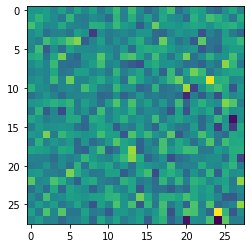

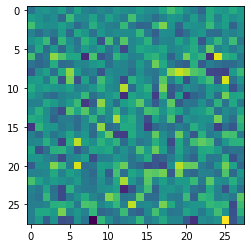

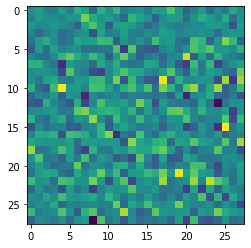

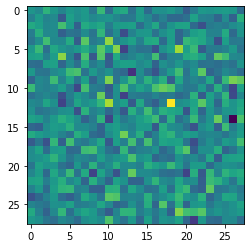

In [7]:
# Create a random noise and generate a sample
noise = tf.random.normal([4, codings_size])
generated_image = generator(noise, training=False)
# Visualize the generated sample

for i in range(4):
    plt.imshow(generated_image[i,:,:,0])
    plt.show()

#### Discriminator

In [8]:
def disc():
  discriminator = Sequential()
  discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                          activation=LeakyReLU(0.4),
                          input_shape=[28, 28, 1]))
                          
  discriminator.add(Dropout(0.5))
  discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                          activation=LeakyReLU(0.4)))
  discriminator.add(Dropout(0.5))
  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation="sigmoid"))
    
  return discriminator 

In [9]:
discriminator = disc()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 212,865
Trainable params: 212,865
Non-tr

In [10]:
discriminator.predict(generated_image) # Not trained, can't know if true or fake, predicts in between --> 0.5

array([[0.4995495 ],
       [0.49833235],
       [0.49894342],
       [0.49902984]], dtype=float32)

### Configure the GAN Network

#### Loss Function

In [11]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

#### Building the subclassed model

In [12]:
batch_size = 32
my_data = X_train

dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [13]:
class GAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.generator = generator
        self.discriminator = discriminator

    
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 
    
    def train_step(self, batch):

        # Get data
        real_images = batch
        fake_images = self.generator(tf.random.normal(shape=[batch_size, codings_size]), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:

            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.25*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.25*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
        
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal(shape=[batch_size, codings_size]), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [14]:
# Create instance of subclassed model
gan = GAN(generator, discriminator)

# Compile the model
gan.compile(g_opt, d_opt, g_loss, d_loss)

In [15]:
hist = gan.fit(dataset, epochs=200)

Epoch 1/200
1875/1875 [==============================] - 18s 8ms/step - d_loss: 0.6989 - g_loss: 0.5829
Epoch 2/200
1875/1875 [==============================] - 16s 9ms/step - d_loss: 0.7030 - g_loss: 0.6668
Epoch 3/200
1875/1875 [==============================] - 16s 9ms/step - d_loss: 0.6992 - g_loss: 0.6832
Epoch 4/200
1875/1875 [==============================] - 16s 8ms/step - d_loss: 0.6968 - g_loss: 0.6911
Epoch 5/200
1875/1875 [==============================] - 16s 8ms/step - d_loss: 0.6953 - g_loss: 0.6990
Epoch 6/200
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6943 - g_loss: 0.7038
Epoch 7/200
1875/1875 [==============================] - 16s 8ms/step - d_loss: 0.6944 - g_loss: 0.7055
Epoch 8/200
1875/1875 [==============================] - 16s 8ms/step - d_loss: 0.6945 - g_loss: 0.7086
Epoch 9/200
1875/1875 [==============================] - 16s 8ms/step - d_loss: 0.6943 - g_loss: 0.7088
Epoch 10/200
1875/1875 [==============================] - 16s 8m

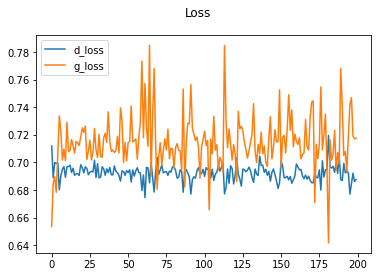

In [16]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

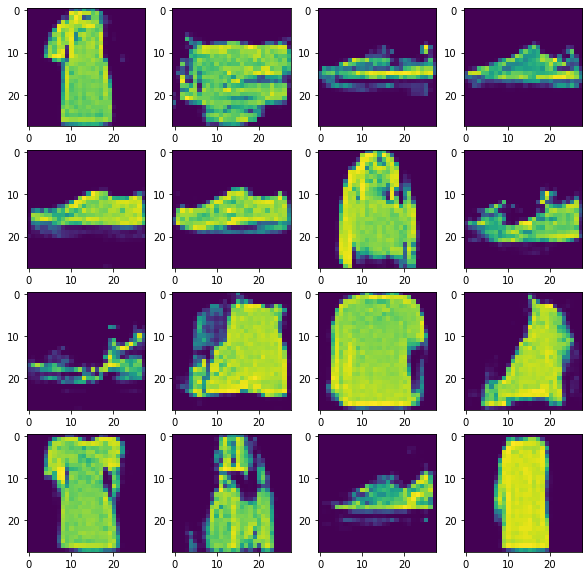

In [17]:
imgs = generator.predict(tf.random.normal((16, codings_size, 1)))
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4):
      a = r*4+c
      ax[r,c].imshow(imgs[a,:,:,0])